In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import metrics

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/train.csv')
valid_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/validation.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/test.csv')

train_df

,label,path
0,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1,0,/content/gdrive/MyDrive/asub_dataset/preproces...
2,1,/content/gdrive/MyDrive/asub_dataset/preproces...
3,0,/content/gdrive/MyDrive/asub_dataset/preproces...
4,0,/content/gdrive/MyDrive/asub_dataset/preproces...
...,...,...
1915,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1916,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1917,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1918,1,/content/gdrive/MyDrive/asub_dataset/preproces...


In [ ]:
# ucitavanje skupa podataka
X_train = []
y_train = []
for i in range(len(train_df)):
    img = cv.imread(train_df['path'][i])

    X_train.append(np.array(img))
    y_train.append(train_df['label'][i])


In [ ]:
# ucitavanje skupa podataka
X_validation = []
y_validation = []
for i in range(len(valid_df)):
    img = cv.imread(valid_df['path'][i])

    X_validation.append(np.array(img))
    y_validation.append(valid_df['label'][i])
    

In [ ]:
# ucitavanje skupa podataka
X_test = []
y_test = []
for i in range(len(test_df)):
    img = cv.imread(test_df['path'][i])

    X_test.append(np.array(img))
    y_test.append(test_df['label'][i])
    

In [ ]:
# pretvorba u numpy array

X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

In [ ]:
#provjera dimenzija

print("Shape X_train: {0}".format(X_train.shape))
print("Shape X_validation: {0}".format(X_validation.shape))
print("Shape X_test: {0}".format(X_test.shape))
print("Shape y_train: {0}".format(y_train.shape))
print("Shape y_validation: {0}".format(y_validation.shape))
print("Shape y_test: {0}".format(y_test.shape))

Shape X_train: (1920, 200, 200, 3)
Shape X_validation: (480, 200, 200, 3)
Shape X_test: (600, 200, 200, 3)
Shape y_train: (1920,)
Shape y_validation: (480,)
Shape y_test: (600,)


In [ ]:
#normalizacija
train_x = tf.keras.utils.normalize(X_train, axis=1)
test_x = tf.keras.utils.normalize(X_test, axis=1)
validation_x = tf.keras.utils.normalize(X_validation, axis=1)

In [ ]:
######## model
# definiramo callback funkcije koje pomazu kod procesa ucenja
# ReduceLROnPlateau cemo koristiti umjesto da optimiramo hiperparametar stope ucenja
# ako u 2 epohe nismo dobili bolji validation loss, smanjujemo za lr za definirani faktor

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-9,
    verbose=1
)

# ovo je callback koji omogućuje spremanje modela ovisno o accuracyu na validation setu
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model',
    monitor='val_acc',
    save_best_only=True,
    verbose=1
)

In [ ]:
## radi se grid search na veličinu batcha
for bs in [16, 32, 64]:
  print('Batch size: {0}\n'.format(bs))

  model_vgg16 = VGG16(
  input_shape=(200, 200, 3),
  include_top=False,
  weights='imagenet'
  )

  for layer in model_vgg16.layers:
      layer.trainable = False

  x = layers.Flatten()(model_vgg16.output)

  ## koristimo dropout za sprečavanje prenaučenosti i bolju generalizaciju
  x = layers.Dropout(0.25)(x)

  x = layers.Dense(units=256, activation="relu")(x)
  x = layers.Dense(units=1, activation="sigmoid")(x)
  model = tf.keras.Model(model_vgg16.input, x)

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics = ['acc']
  )

  vgg = model.fit(x=train_x, y=y_train, 
                  validation_data=(validation_x, y_validation),
                  batch_size=bs,
                  epochs=40, 
                  verbose=1, 
                  callbacks=[reduce_lr, checkpoint_callback])

Batch size: 16

Epoch 1/40
120/120 [==============================] - ETA: 0s - loss: 0.6645 - acc: 0.6938
Epoch 1: val_acc improved from -inf to 0.87500, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 14s 114ms/step - loss: 0.6645 - acc: 0.6938 - val_loss: 0.3551 - val_acc: 0.8750 - lr: 0.0010
Epoch 2/40
120/120 [==============================] - ETA: 0s - loss: 0.3619 - acc: 0.8495
Epoch 2: val_acc improved from 0.87500 to 0.91042, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 13s 105ms/step - loss: 0.3619 - acc: 0.8495 - val_loss: 0.2821 - val_acc: 0.9104 - lr: 0.0010
Epoch 3/40
120/120 [==============================] - ETA: 0s - loss: 0.3124 - acc: 0.8745
Epoch 3: val_acc improved from 0.91042 to 0.91667, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 13s 107ms/step - loss: 0.3124 - acc: 0.8745 - val_loss: 0.2557 - val_acc: 0.9167 - lr: 0.0010
Epoch 4/40
120/120 [==============================] - ETA: 0s - loss: 0.2536 - acc: 0.8927
Epoch 4: val_acc did not improve from 0.91667
120/120 [==============================] - 11s 91ms/step - loss: 0.2536 - acc: 0.8927 - val_loss: 0.3160 - val_acc: 0.8625 - lr: 0.0010
Epoch 5/40
120/120 [==============================] - ETA: 0s - loss: 0.2300 - acc: 0.9104
Epoch 5: val_acc did not improve from 0.91667
120/120 [==============================] - 11s 94ms/step - loss: 0.2300 - acc: 0.9104 - val_loss: 0.2481 - val_acc: 0.9021 - lr: 0.0010
Epoch 6/40
120/120 [==============================] - ETA: 0s - loss: 0.2198 - acc: 0.9073
Epoch 6: val_acc improved from 0.91667 to 0.94167, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 14s 116ms/step - loss: 0.2198 - acc: 0.9073 - val_loss: 0.1945 - val_acc: 0.9417 - lr: 0.0010
Epoch 7/40
120/120 [==============================] - ETA: 0s - loss: 0.2307 - acc: 0.9000
Epoch 7: val_acc did not improve from 0.94167
120/120 [==============================] - 11s 96ms/step - loss: 0.2307 - acc: 0.9000 - val_loss: 0.5868 - val_acc: 0.7375 - lr: 0.0010
Epoch 8/40
120/120 [==============================] - ETA: 0s - loss: 0.1933 - acc: 0.9245
Epoch 8: val_acc did not improve from 0.94167
120/120 [==============================] - 12s 97ms/step - loss: 0.1933 - acc: 0.9245 - val_loss: 0.4764 - val_acc: 0.7896 - lr: 0.0010
Epoch 9/40
120/120 [==============================] - ETA: 0s - loss: 0.1443 - acc: 0.9422
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 9: val_acc did not improve from 0.94167
120/120 [==============================] - 12s 98ms/step - loss: 0.1443 - acc: 0.9422 - val_loss: 0.25

120/120 [==============================] - 14s 115ms/step - loss: 0.0945 - acc: 0.9729 - val_loss: 0.1570 - val_acc: 0.9458 - lr: 2.0000e-04
Epoch 12/40
120/120 [==============================] - ETA: 0s - loss: 0.0985 - acc: 0.9677
Epoch 12: val_acc did not improve from 0.94583
120/120 [==============================] - 12s 98ms/step - loss: 0.0985 - acc: 0.9677 - val_loss: 0.1719 - val_acc: 0.9396 - lr: 2.0000e-04
Epoch 13/40
120/120 [==============================] - ETA: 0s - loss: 0.0876 - acc: 0.9786
Epoch 13: val_acc improved from 0.94583 to 0.95833, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 14s 115ms/step - loss: 0.0876 - acc: 0.9786 - val_loss: 0.1486 - val_acc: 0.9583 - lr: 2.0000e-04
Epoch 14/40
120/120 [==============================] - ETA: 0s - loss: 0.0824 - acc: 0.9729
Epoch 14: val_acc did not improve from 0.95833
120/120 [==============================] - 11s 95ms/step - loss: 0.0824 - acc: 0.9729 - val_loss: 0.1631 - val_acc: 0.9375 - lr: 2.0000e-04
Epoch 15/40
120/120 [==============================] - ETA: 0s - loss: 0.0911 - acc: 0.9677
Epoch 15: val_acc did not improve from 0.95833
120/120 [==============================] - 11s 96ms/step - loss: 0.0911 - acc: 0.9677 - val_loss: 0.1465 - val_acc: 0.9542 - lr: 2.0000e-04
Epoch 16/40
120/120 [==============================] - ETA: 0s - loss: 0.0782 - acc: 0.9760
Epoch 16: val_acc did not improve from 0.95833
120/120 [==============================] - 12s 99ms/step - loss: 0.0782 - acc: 0.9760 - val_loss: 0.1432 - val_acc: 0.9521 - lr: 2.0000e-04
Epoch 17/40
120/120 [=

120/120 [==============================] - 14s 116ms/step - loss: 0.0520 - acc: 0.9865 - val_loss: 0.1305 - val_acc: 0.9604 - lr: 4.0000e-05
Epoch 28/40
120/120 [==============================] - ETA: 0s - loss: 0.0457 - acc: 0.9885
Epoch 28: val_acc improved from 0.96042 to 0.96250, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best model-optimization


120/120 [==============================] - 14s 114ms/step - loss: 0.0457 - acc: 0.9885 - val_loss: 0.1291 - val_acc: 0.9625 - lr: 4.0000e-05
Epoch 29/40
120/120 [==============================] - ETA: 0s - loss: 0.0444 - acc: 0.9880
Epoch 29: val_acc did not improve from 0.96250
120/120 [==============================] - 12s 98ms/step - loss: 0.0444 - acc: 0.9880 - val_loss: 0.1286 - val_acc: 0.9625 - lr: 4.0000e-05
Epoch 30/40
120/120 [==============================] - ETA: 0s - loss: 0.0469 - acc: 0.9870
Epoch 30: val_acc did not improve from 0.96250
120/120 [==============================] - 12s 98ms/step - loss: 0.0469 - acc: 0.9870 - val_loss: 0.1571 - val_acc: 0.9458 - lr: 4.0000e-05
Epoch 31/40
120/120 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9880
Epoch 31: val_acc did not improve from 0.96250
120/120 [==============================] - 12s 99ms/step - loss: 0.0453 - acc: 0.9880 - val_loss: 0.1348 - val_acc: 0.9563 - lr: 4.0000e-05
Epoch 32/40
120/120 [=

In [ ]:
#optimiramo jos broj neuorona u dodanom poptuno povezanom sloju
for ns in [128, 512]:
  print('Number of neurons: {0}\n'.format(ns))

  model_vgg16 = VGG16(
  input_shape=(200, 200, 3),
  include_top=False,
  weights='imagenet'
  )

  for layer in model_vgg16.layers:
      layer.trainable = False

  x = layers.Flatten()(model_vgg16.output)
  x = layers.Dropout(0.25)(x)

  x = layers.Dense(units=ns, activation="relu")(x)
  x = layers.Dense(units=1, activation="sigmoid")(x)

  model = tf.keras.Model(model_vgg16.input, x)

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics = ['acc']
  )

  vgg = model.fit(x=train_x, y=y_train, 
                  validation_data=(validation_x, y_validation),
                  batch_size=16,
                  epochs=40, 
                  verbose=1, 
                  callbacks=[reduce_lr, checkpoint_callback])

Number of neurons: 128

Epoch 1/40
120/120 [==============================] - ETA: 0s - loss: 0.6827 - acc: 0.6427
Epoch 1: val_acc improved from -inf to 0.79375, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 16s 126ms/step - loss: 0.6827 - acc: 0.6427 - val_loss: 0.4680 - val_acc: 0.7937 - lr: 0.0010
Epoch 2/40
120/120 [==============================] - ETA: 0s - loss: 0.4218 - acc: 0.8219
Epoch 2: val_acc improved from 0.79375 to 0.87292, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 14s 114ms/step - loss: 0.4218 - acc: 0.8219 - val_loss: 0.3470 - val_acc: 0.8729 - lr: 0.0010
Epoch 3/40
120/120 [==============================] - ETA: 0s - loss: 0.3315 - acc: 0.8708
Epoch 3: val_acc improved from 0.87292 to 0.90208, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 14s 115ms/step - loss: 0.3315 - acc: 0.8708 - val_loss: 0.3044 - val_acc: 0.9021 - lr: 0.0010
Epoch 4/40
120/120 [==============================] - ETA: 0s - loss: 0.2734 - acc: 0.8990
Epoch 4: val_acc improved from 0.90208 to 0.91458, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 14s 118ms/step - loss: 0.2734 - acc: 0.8990 - val_loss: 0.2499 - val_acc: 0.9146 - lr: 0.0010
Epoch 5/40
120/120 [==============================] - ETA: 0s - loss: 0.2400 - acc: 0.9099
Epoch 5: val_acc did not improve from 0.91458
120/120 [==============================] - 12s 96ms/step - loss: 0.2400 - acc: 0.9099 - val_loss: 0.2307 - val_acc: 0.9146 - lr: 0.0010
Epoch 6/40
120/120 [==============================] - ETA: 0s - loss: 0.2401 - acc: 0.8974
Epoch 6: val_acc improved from 0.91458 to 0.93125, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 14s 117ms/step - loss: 0.2401 - acc: 0.8974 - val_loss: 0.1973 - val_acc: 0.9312 - lr: 0.0010
Epoch 7/40
120/120 [==============================] - ETA: 0s - loss: 0.1910 - acc: 0.9297
Epoch 7: val_acc improved from 0.93125 to 0.93958, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model


120/120 [==============================] - 14s 116ms/step - loss: 0.1910 - acc: 0.9297 - val_loss: 0.1859 - val_acc: 0.9396 - lr: 0.0010
Epoch 8/40
120/120 [==============================] - ETA: 0s - loss: 0.1668 - acc: 0.9370
Epoch 8: val_acc did not improve from 0.93958
120/120 [==============================] - 12s 98ms/step - loss: 0.1668 - acc: 0.9370 - val_loss: 0.2728 - val_acc: 0.8833 - lr: 0.0010
Epoch 9/40
120/120 [==============================] - ETA: 0s - loss: 0.1522 - acc: 0.9432
Epoch 9: val_acc did not improve from 0.93958
120/120 [==============================] - 11s 95ms/step - loss: 0.1522 - acc: 0.9432 - val_loss: 0.2575 - val_acc: 0.8875 - lr: 0.0010
Epoch 10/40
120/120 [==============================] - ETA: 0s - loss: 0.1420 - acc: 0.9427
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_acc did not improve from 0.93958
120/120 [==============================] - 11s 95ms/step - loss: 0.1420 - acc: 0.9427 - val_loss: 0

120/120 [==============================] - 14s 116ms/step - loss: 0.1077 - acc: 0.9677 - val_loss: 0.1520 - val_acc: 0.9563 - lr: 2.0000e-04
Epoch 12/40
120/120 [==============================] - ETA: 0s - loss: 0.0970 - acc: 0.9719
Epoch 12: val_acc did not improve from 0.95625
120/120 [==============================] - 11s 95ms/step - loss: 0.0970 - acc: 0.9719 - val_loss: 0.1813 - val_acc: 0.9229 - lr: 2.0000e-04
Epoch 13/40
120/120 [==============================] - ETA: 0s - loss: 0.0947 - acc: 0.9708
Epoch 13: val_acc did not improve from 0.95625
120/120 [==============================] - 12s 98ms/step - loss: 0.0947 - acc: 0.9708 - val_loss: 0.1483 - val_acc: 0.9521 - lr: 2.0000e-04
Epoch 14/40
120/120 [==============================] - ETA: 0s - loss: 0.0925 - acc: 0.9719
Epoch 14: val_acc did not improve from 0.95625
120/120 [==============================] - 12s 98ms/step - loss: 0.0925 - acc: 0.9719 - val_loss: 0.1741 - val_acc: 0.9333 - lr: 2.0000e-04
Epoch 15/40
120/120 [=

120/120 [==============================] - 14s 115ms/step - loss: 0.1081 - acc: 0.9620 - val_loss: 0.1434 - val_acc: 0.9604 - lr: 2.0000e-04
Epoch 16/40
120/120 [==============================] - ETA: 0s - loss: 0.0817 - acc: 0.9729
Epoch 16: val_acc did not improve from 0.96042
120/120 [==============================] - 12s 98ms/step - loss: 0.0817 - acc: 0.9729 - val_loss: 0.1568 - val_acc: 0.9458 - lr: 2.0000e-04
Epoch 17/40
120/120 [==============================] - ETA: 0s - loss: 0.0809 - acc: 0.9755
Epoch 17: val_acc did not improve from 0.96042
120/120 [==============================] - 11s 95ms/step - loss: 0.0809 - acc: 0.9755 - val_loss: 0.1412 - val_acc: 0.9604 - lr: 2.0000e-04
Epoch 18/40
120/120 [==============================] - ETA: 0s - loss: 0.0779 - acc: 0.9745
Epoch 18: val_acc did not improve from 0.96042
120/120 [==============================] - 11s 95ms/step - loss: 0.0779 - acc: 0.9745 - val_loss: 0.1598 - val_acc: 0.9438 - lr: 2.0000e-04
Epoch 19/40
120/120 [=

120/120 [==============================] - 14s 117ms/step - loss: 0.0687 - acc: 0.9802 - val_loss: 0.1341 - val_acc: 0.9667 - lr: 2.0000e-04
Epoch 23/40
120/120 [==============================] - ETA: 0s - loss: 0.0818 - acc: 0.9693
Epoch 23: val_acc did not improve from 0.96667
120/120 [==============================] - 12s 97ms/step - loss: 0.0818 - acc: 0.9693 - val_loss: 0.1359 - val_acc: 0.9625 - lr: 2.0000e-04
Epoch 24/40
120/120 [==============================] - ETA: 0s - loss: 0.0703 - acc: 0.9786
Epoch 24: val_acc did not improve from 0.96667
120/120 [==============================] - 12s 98ms/step - loss: 0.0703 - acc: 0.9786 - val_loss: 0.1531 - val_acc: 0.9458 - lr: 2.0000e-04
Epoch 25/40
120/120 [==============================] - ETA: 0s - loss: 0.0808 - acc: 0.9771
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 25: val_acc did not improve from 0.96667
120/120 [==============================] - 12s 98ms/step - loss: 0.0808 - acc: 0.97

Najbolji rezultat koji smo dobili što se tiče accuracy-a, iznosi 96.996%
na validation setu.

In [ ]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model')

In [ ]:
score = loaded_model.evaluate(test_x, y_test, verbose=1)

19/19 [==============================] - 3s 143ms/step - loss: 0.1354 - acc: 0.9633


In [ ]:
output = loaded_model.predict(test_x, verbose=True)
y_predicted = np.where(output > .5, 1, 0)

accuracy = metrics.accuracy_score(y_test, y_predicted)
recall = metrics.recall_score(y_test, y_predicted)
f1 = metrics.f1_score(y_test, y_predicted)

print(f'Accuracy: {accuracy}; Recall: {recall}; F1: {f1}')

Accuracy: 0.9633333333333334; Recall: 0.975609756097561; F1: 0.9621993127147767


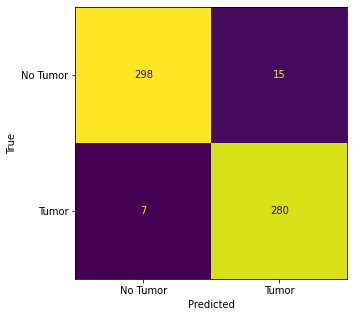

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predicted, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)

Prethodno su prikazani rezultati na test setu. Vidimo zadovoljavajuće rezultate.